# TRM Model Inference Notebook

This notebook demonstrates how to load a trained TRM model and run inference on specific puzzles, visualizing the results with standard metrics.

## Features:
- Load trained TRM model from checkpoint
- Run inference on specific puzzles
- Compute standard metrics (accuracy, exact accuracy, steps, etc.)
- Visualize puzzle inputs, expected outputs, and model predictions
- Plot metrics and results


In [1]:
# Import necessary libraries
import os
import json
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import Dict, List, Optional, Tuple, Any
from PIL import Image
import io

# Import TRM-specific modules
from dataset.common import PuzzleDatasetMetadata
from evaluators.arc import create_arc_grid_ax

# Import pydantic models and functions from pretrain.py
from pretrain import (
    create_model, 
    PretrainConfig, 
    ArchConfig, 
    LossConfig, 
    EvaluatorConfig,
    load_checkpoint
)
import pydantic

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


/home/ubuntu/trm-washington/TinyRecursiveModels/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/ubuntu/trm-washington/TinyRecursiveModels/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by 

Using device: cuda


## Configuration

Set up the paths and parameters for your trained model and dataset.


In [2]:
class InferenceConfig(pydantic.BaseModel):

    arch: ArchConfig
    puzzle_metadata: PuzzleDatasetMetadata
    load_checkpoint: str
    data_paths: list[str]
    data_paths_test: list[str] = []

    batch_size: int

    dropout: float

    seed: int

def _load_metadata(split: str, dataset_path: str) -> PuzzleDatasetMetadata:
    with open(os.path.join(dataset_path, split, "dataset.json"), "r") as f:
        return PuzzleDatasetMetadata(**json.load(f))


loss_config = LossConfig(**{
    "name":"losses@ACTLossHead",
    "loss_type":"stablemax_cross_entropy",
    "differential_loss":True
})

arch_config = ArchConfig(**{
    "name":"recursive_reasoning.trmjd@TinyRecursiveReasoningModelJD_ACTV1",
    "loss": loss_config,

    "halt_exploration_prob":0.1,
    "halt_max_steps":16,

    "H_cycles":3,
    "L_cycles":6,
    
    "H_layers":0,
    "L_layers":2,
    
    "hidden_size":512,
    "num_heads":8,
    "expansion":4,
    
    "puzzle_emb_ndim":512,

    "pos_encodings":"rope",
    "forward_dtype":"bfloat16",

    "mlp_t":False,
    "puzzle_emb_len":16,
    "no_ACT_continue": True,
})

puzzle_metadata = PuzzleDatasetMetadata(
    vocab_size=12,
    seq_len=900,
    num_puzzle_identifiers=1000,
    total_puzzles=1000,
    total_groups=1000,
    mean_puzzle_examples=1000,
    sets=["train", "test"],
    pad_id=0,
    ignore_label_id=None,
    blank_identifier_id=1
)

inference_config = InferenceConfig(
    arch=arch_config,
    puzzle_metadata=puzzle_metadata,
    load_checkpoint="checkpoints/my_saves/lambda_arc2eval-aug-200_H4_L3_hid512_lr1e-04_continue/step_28644",    #"checkpoints/downloaded/Sanjin2024_TinyRecursiveModels-ARC-AGI-2/step_217602", # checkpoints/my_saves/lambda_arc2eval-aug-200_H3_L2_hid512_lr2e-04_stack_internal_losses_continue/step_3720",
    data_paths=["data/arc2eval-aug-100"],
    batch_size=50,
    dropout=0.0,
    seed=0
)

puzzle_metadata = _load_metadata("test", inference_config.data_paths[0])


## Model Loading

Load the trained TRM model from checkpoint using the existing `create_model` function from `pretrain.py` for better compatibility and consistency with the training infrastructure.


In [3]:
from utils.functions import load_model_class


def load_trm_model(inference_config: InferenceConfig) -> nn.Module:
    """Load TRM model from checkpoint."""
    
    # Model configuration
    model_cfg = dict(
        **inference_config.arch.__pydantic_extra__, # type: ignore
        batch_size=inference_config.batch_size,
        vocab_size=inference_config.puzzle_metadata.vocab_size,
        seq_len=inference_config.puzzle_metadata.seq_len,
        num_puzzle_identifiers=inference_config.puzzle_metadata.num_puzzle_identifiers,
        causal=False,
        dropout=inference_config.dropout
    )
    
    # Load model class
    model_cls = load_model_class(inference_config.arch.name)
    loss_head_cls = load_model_class(inference_config.arch.loss.name)
    
    # Create model
    with torch.device(device):
        model = model_cls(model_cfg)
        print(model)
        model = loss_head_cls(model, **(inference_config.arch.loss.__pydantic_extra__)) # type: ignore
        
        load_checkpoint(model, inference_config) # type: ignore
    
    model.eval()
    return model

# Load the model
model = load_trm_model(inference_config)
print(f"Model loaded on {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


TinyRecursiveReasoningModelJD_ACTV1(
  (inner): TinyRecursiveReasoningModelJD_ACTV1_Inner(
    (embed_tokens): CastedEmbedding()
    (lm_head): CastedLinear()
    (q_head): CastedLinear()
    (puzzle_emb): CastedSparseEmbedding()
    (rotary_emb): RotaryEmbedding()
    (L_level): TinyRecursiveReasoningModelJD_ACTV1ReasoningModule(
      (layers): ModuleList(
        (0-1): 2 x TinyRecursiveReasoningModelJD_ACTV1Block(
          (self_attn): Attention(
            (qkv_proj): CastedLinear()
            (o_proj): CastedLinear()
          )
          (mlp): SwiGLU(
            (gate_up_proj): CastedLinear()
            (down_proj): CastedLinear()
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
)
Loading checkpoint checkpoints/my_saves/lambda_arc2eval-aug-200_H4_L3_hid512_lr1e-04_continue/step_28644
Removing _orig_mod prefix from state_dict keys
Resetting puzzle embedding as shape is different. Found torch.Size([23992, 512]), Expected torch.Size([

## Load Test Puzzles

Load specific puzzles for inference. This example loads ARC-AGI puzzles.


In [4]:
from pretrain import create_dataloader


eval_loader,  eval_metadata  = create_dataloader(inference_config, "test", test_set_mode=True, epochs_per_iter=1, global_batch_size=inference_config.batch_size, rank=0, world_size=1)

## Inference Function

Run inference on specific puzzles and collect metrics.


In [5]:
from evaluators.arc import ARC
# evaluator = ARC(
#     data_path=inference_config.data_paths[0],
#     eval_metadata=puzzle_metadata,
# )



In [6]:
carry = None
processed_batches = 0
evaluators = [ARC(
    data_path=inference_config.data_paths[0],
    eval_metadata=puzzle_metadata,
) for i in range(inference_config.arch.halt_max_steps)]

for set_name, batch, global_batch_size in eval_loader:
    processed_batches += 1
    print(f"Processing batch {processed_batches}: {set_name}")
    
    # To device
    batch = {k: v.cuda() for k, v in batch.items()}
    with torch.device("cuda"):
        carry = model.initial_carry(batch)  # type: ignore

    # Forward
    inference_steps = 0
    while True:
        carry, losses, metrics, preds, all_finish = model(
            carry=carry, batch=batch, return_keys=["preds", "q_halt_logits"]
        )
        inference_steps += 1

        evaluators[inference_steps - 1].update_batch(batch, preds)

        if all_finish:
            break

    print(f"  Completed inference in {inference_steps} steps")


    del carry, losses, preds, batch, all_finish

Processing batch 1: all
  Completed inference in 16 steps
Processing batch 2: all
  Completed inference in 16 steps
Processing batch 3: all
  Completed inference in 16 steps
Processing batch 4: all
  Completed inference in 16 steps
Processing batch 5: all
  Completed inference in 16 steps
Processing batch 6: all
  Completed inference in 16 steps
Processing batch 7: all
  Completed inference in 16 steps
Processing batch 8: all
  Completed inference in 16 steps
Processing batch 9: all
  Completed inference in 16 steps
Processing batch 10: all
  Completed inference in 16 steps
Processing batch 11: all
  Completed inference in 16 steps
Processing batch 12: all
  Completed inference in 16 steps
Processing batch 13: all
  Completed inference in 16 steps
Processing batch 14: all
  Completed inference in 16 steps
Processing batch 15: all
  Completed inference in 16 steps
Processing batch 16: all
  Completed inference in 16 steps
Processing batch 17: all
  Completed inference in 16 steps
Proces

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [14]:
len(evaluators)

16

In [7]:
results = [evaluator.result(
    save_path=None,
    rank=0,
    world_size=1
) for evaluator in evaluators]

Puzzle 5961cc34 is correct for pass@5
Puzzle 5961cc34 is correct for pass@10
Puzzle 5961cc34 is correct for pass@100
Puzzle 5961cc34 is correct for pass@1000
Puzzle 7666fa5d is correct for pass@10
Puzzle 7666fa5d is correct for pass@100
Puzzle 7666fa5d is correct for pass@1000
Puzzle 291dc1e1 has no predictions.
Puzzle 7ed72f31 has no predictions.
Puzzle 7ed72f31 has no predictions.
Puzzle 20a9e565 has no predictions.
Puzzle 20a9e565 has no predictions.
Puzzle 4c416de3 has no predictions.
Puzzle b10624e5 has no predictions.
Puzzle b6f77b65 has no predictions.
Puzzle b6f77b65 has no predictions.
Puzzle b6f77b65 has no predictions.
Puzzle e12f9a14 has no predictions.
Puzzle e12f9a14 has no predictions.
Puzzle 0934a4d8 has no predictions.
Puzzle b0039139 has no predictions.
Puzzle b0039139 has no predictions.
Puzzle db695cfb has no predictions.
Puzzle 8698868d has no predictions.
Puzzle 5dbc8537 has no predictions.
Puzzle 5dbc8537 has no predictions.
Puzzle 409aa875 has no predictions.
Pu

/lambda/nfs/trm-washington/TinyRecursiveModels/evaluators/arc.py:86: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(grid_plot, cmap=cmap, vmin=-1, vmax=9)
/lambda/nfs/trm-washington/TinyRecursiveModels/evaluators/arc.py:86: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(grid_plot, cmap=cmap, vmin=-1, vmax=9)


Puzzle 291dc1e1 has no predictions.
Puzzle 7ed72f31 has no predictions.
Puzzle 7ed72f31 has no predictions.
Puzzle 20a9e565 has no predictions.
Puzzle 20a9e565 has no predictions.
Puzzle 4c416de3 has no predictions.
Puzzle b10624e5 has no predictions.
Puzzle b6f77b65 has no predictions.
Puzzle b6f77b65 has no predictions.
Puzzle b6f77b65 has no predictions.
Puzzle e12f9a14 has no predictions.
Puzzle e12f9a14 has no predictions.
Puzzle 0934a4d8 has no predictions.
Puzzle b0039139 has no predictions.
Puzzle b0039139 has no predictions.
Puzzle db695cfb has no predictions.
Puzzle 8698868d has no predictions.
Puzzle 5dbc8537 has no predictions.
Puzzle 5dbc8537 has no predictions.
Puzzle 409aa875 has no predictions.
Puzzle 8b7bacbf has no predictions.
Puzzle 8b7bacbf has no predictions.
Puzzle 58490d8a has no predictions.
Puzzle 21897d95 has no predictions.
Puzzle 21897d95 has no predictions.
Puzzle 269e22fb has no predictions.
Puzzle 269e22fb has no predictions.
Puzzle edb79dae has no predi

In [11]:
for result in results:
    print(result["ARC/pass@1000"])

print(results[-1].keys())
print()

0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
dict_keys(['ARC/pass@1', 'ARC/pass@2', 'ARC/pass@5', 'ARC/pass@10', 'ARC/pass@100', 'ARC/pass@1000', 'ARC/viz/5961cc34_0', 'ARC/viz/64efde09_0', 'ARC/viz/142ca369_0', 'ARC/viz/142ca369_1', 'ARC/viz/7666fa5d_0', 'ARC/viz/36a08778_0', 'ARC/viz/36a08778_1', 'ARC/viz/80a900e0_0', 'ARC/viz/8f215267_0', 'ARC/viz/20270e3b_0', 'ARC/viz/20270e3b_1', 'ARC/viz/5545f144_0', 'ARC/viz/de809cff_0'])



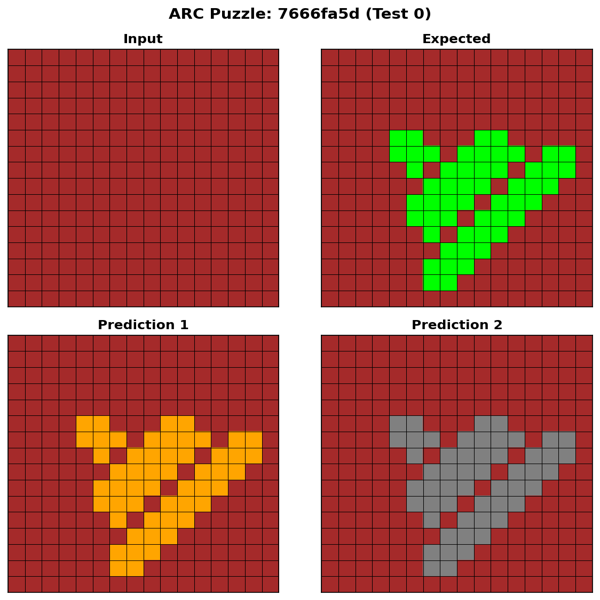

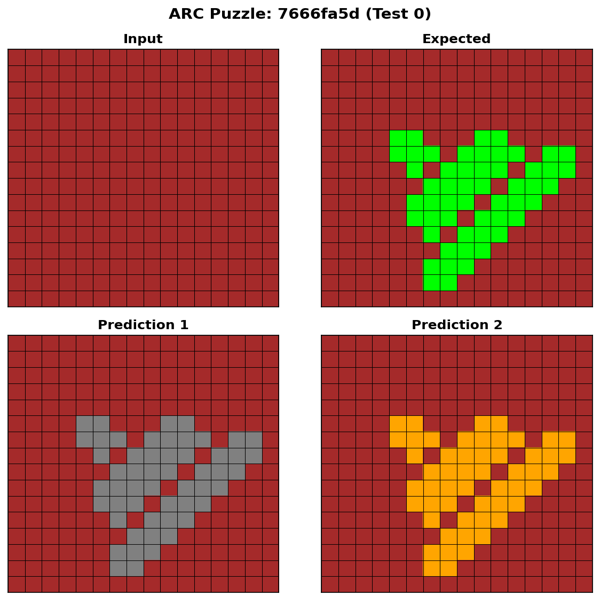

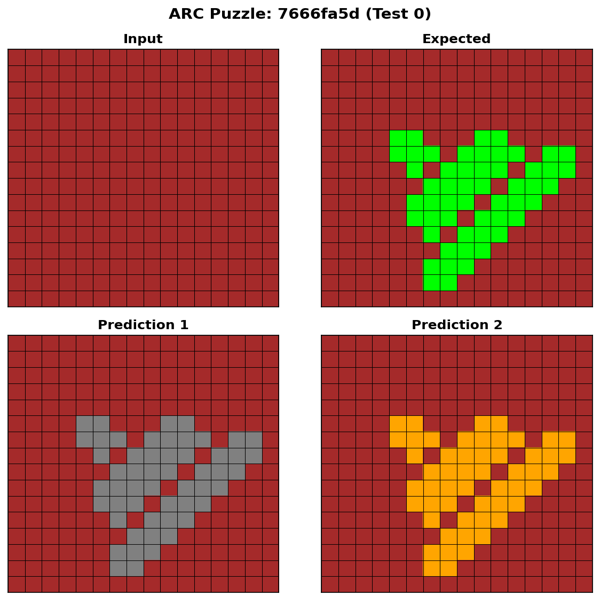

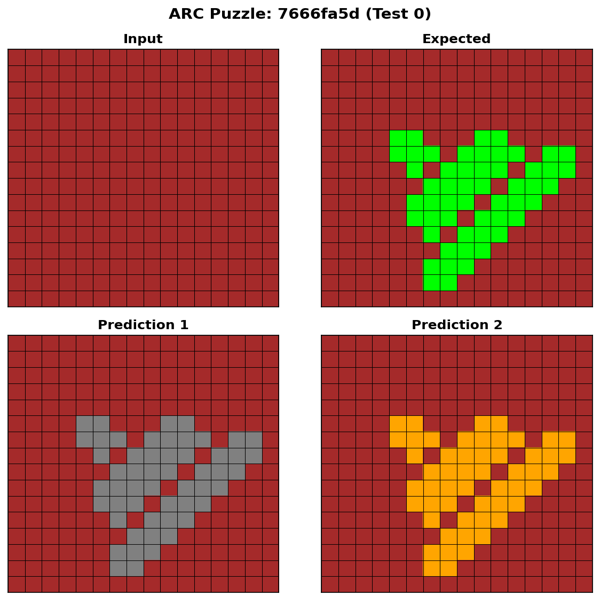

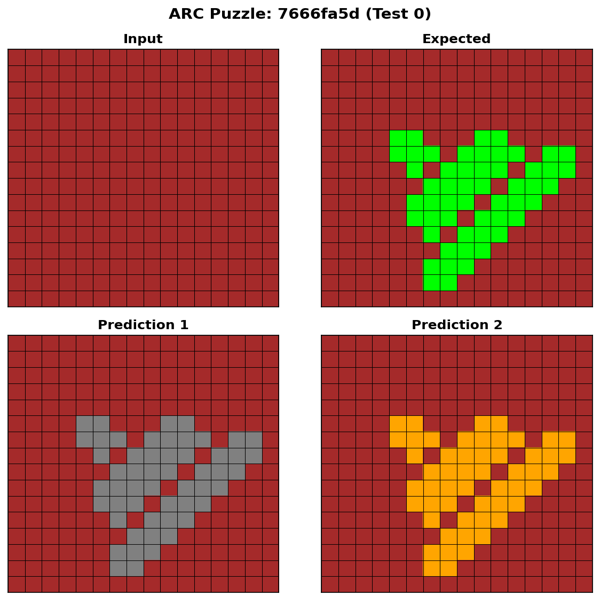

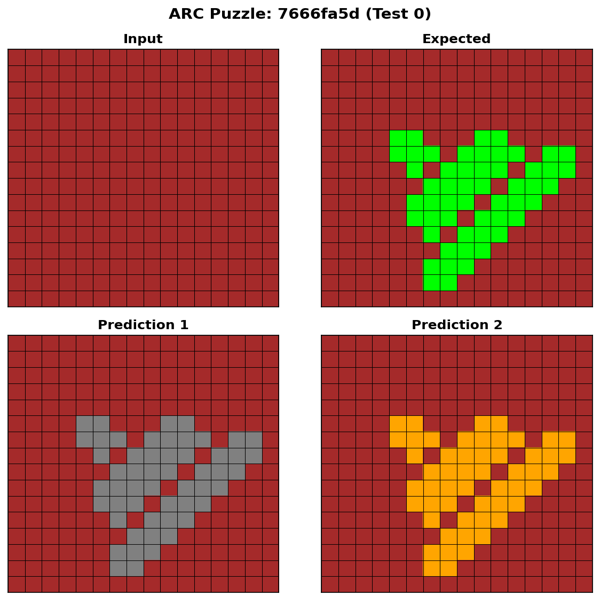

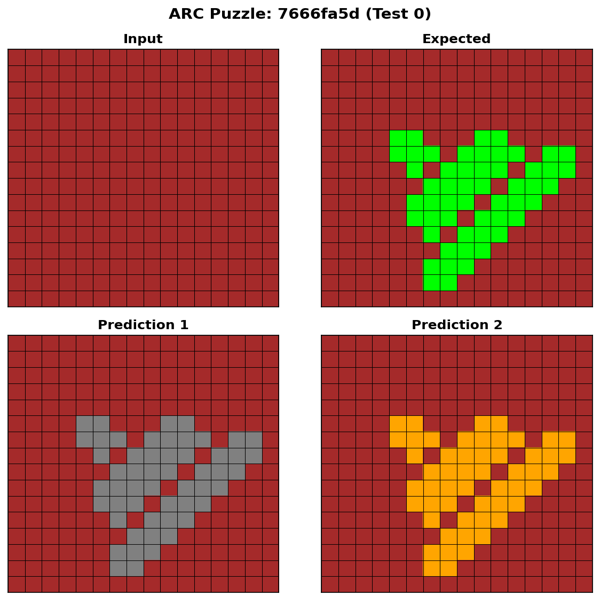

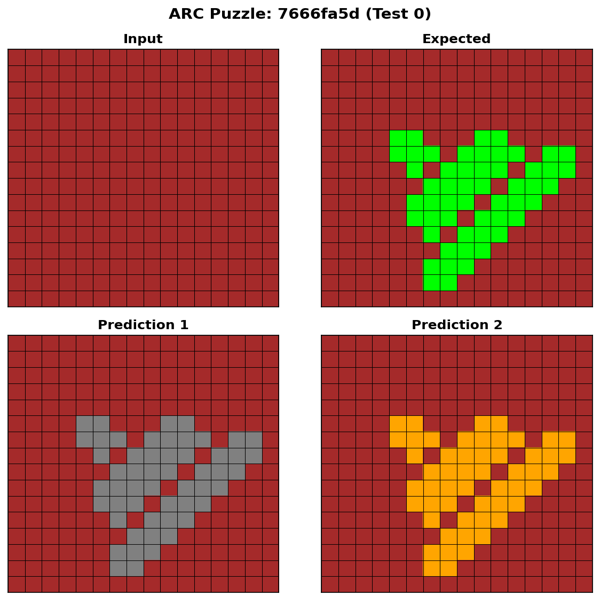

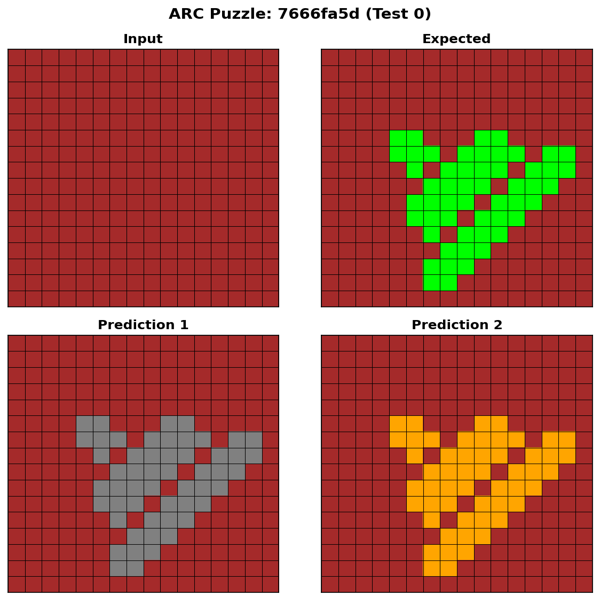

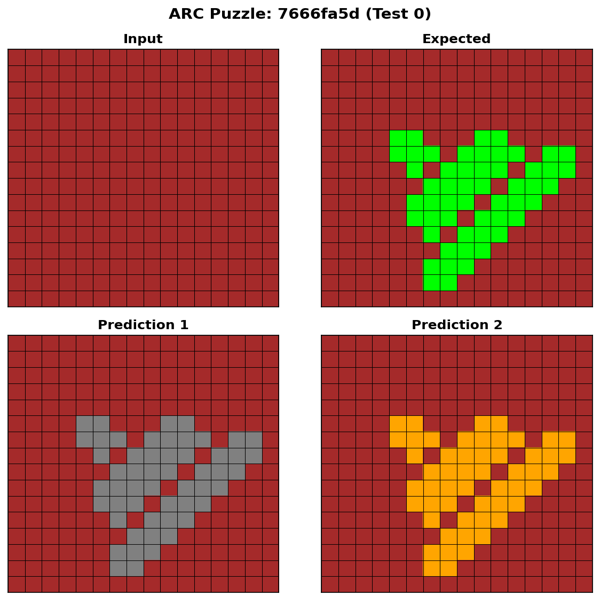

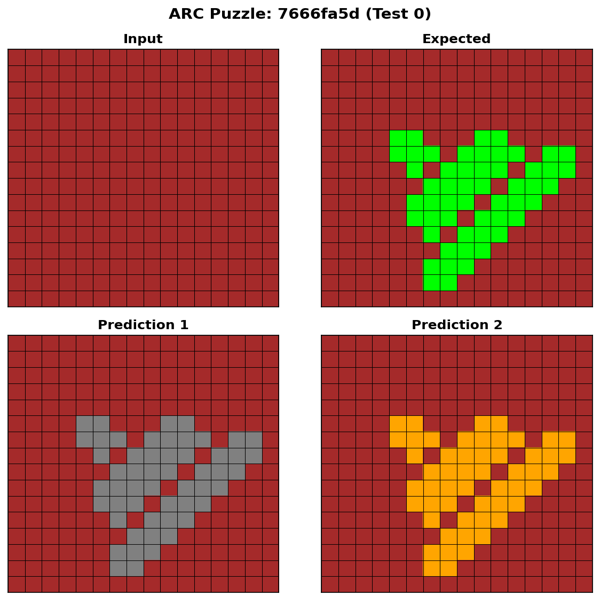

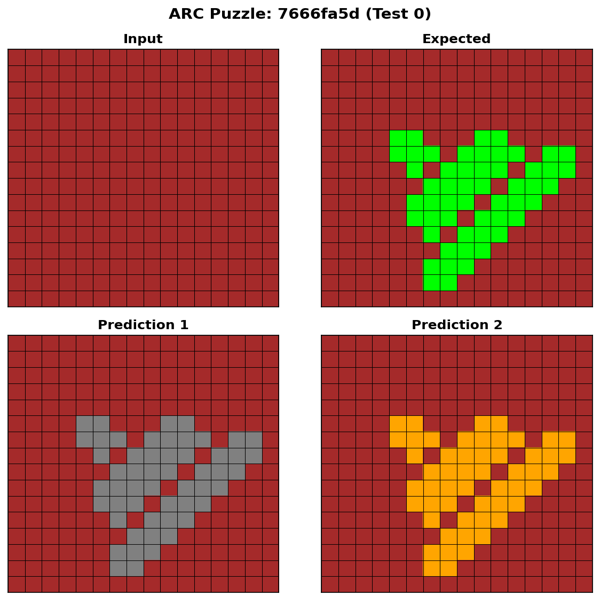

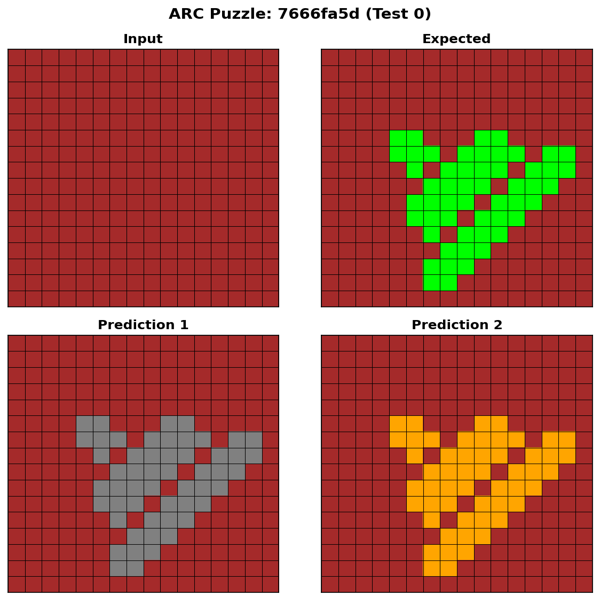

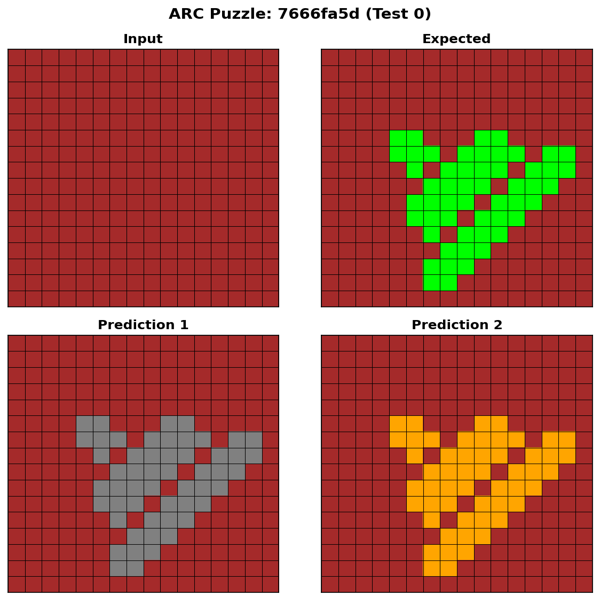

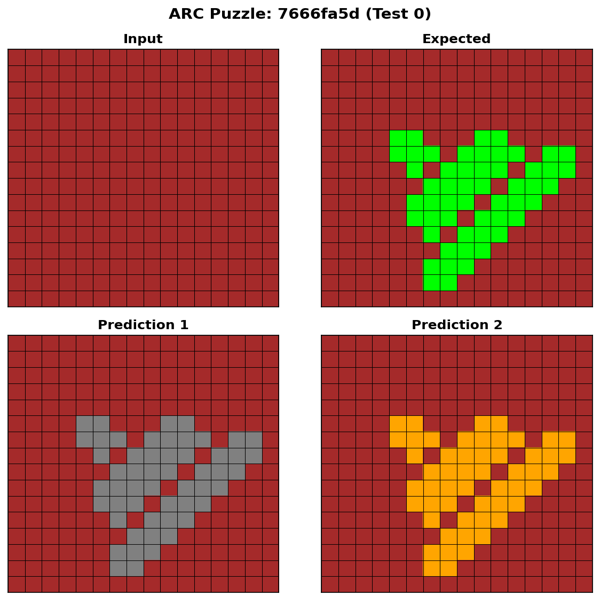

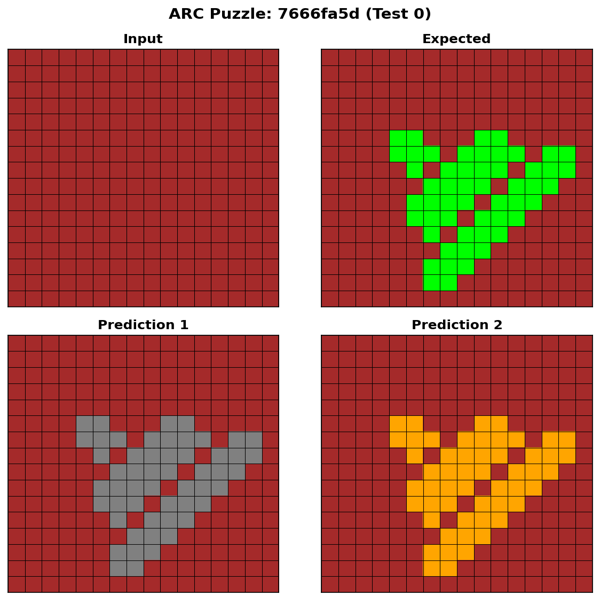

In [13]:
for result in results:
    display(result['ARC/viz/7666fa5d_0'].image.resize((600, 600)))

## Visualization

Create visualizations for the puzzle inputs, expected outputs, and model predictions.



Visualizing results for puzzle: de809cff


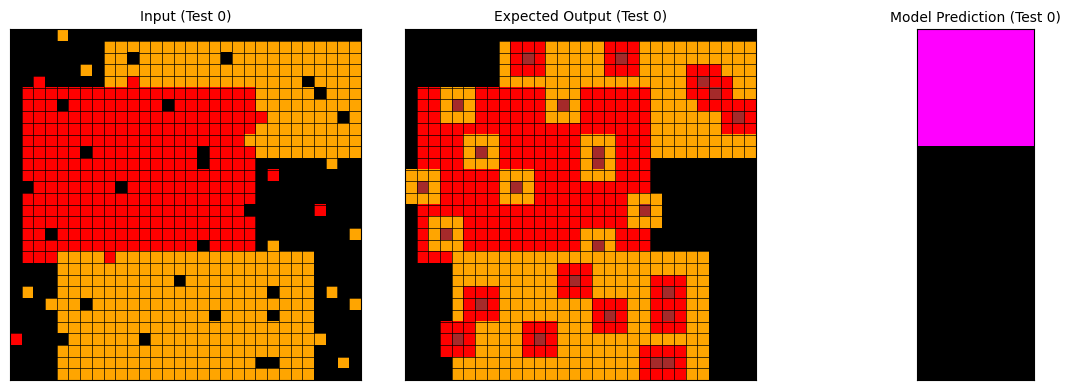

In [44]:
def visualize_puzzle_results(results: dict[str, Any]) -> None:
    """Visualize results for a single puzzle."""
    
    puzzle_name = results["puzzle_name"]
    test_cases = results["test_cases"]
    
    print(f"\nVisualizing results for puzzle: {puzzle_name}")
    
    for test_case in test_cases:
        test_idx = test_case["test_idx"]
        input_grid = test_case["input_grid"]
        expected_grid = test_case["expected_grid"]
        predictions = test_case["predictions"]
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        
        create_arc_grid_ax(input_grid, axes[0], title=f"Input (Test {test_idx})")
        create_arc_grid_ax(expected_grid, axes[1], title=f"Expected Output (Test {test_idx})")
        create_arc_grid_ax(predictions, axes[2], title=f"Model Prediction (Test {test_idx})")

        plt.tight_layout()
        plt.show()

# Visualize results for each puzzle
for result in inference_results:
    visualize_puzzle_results(result)


## Metrics Analysis

Compute and plot comprehensive metrics across all puzzles.


## Summary: Pydantic Integration Complete

This notebook now properly integrates all pydantic models from the codebase:

### ✅ **Imported Pydantic Models:**
- `PuzzleDatasetMetadata` from `dataset.common` - for dataset metadata validation
- `LossConfig`, `ArchConfig`, `EvaluatorConfig`, `PretrainConfig` from `pretrain.py` - for model configuration
- `dihedral_transform`, `inverse_dihedral_transform` from `dataset.common` - for data transformations

### ✅ **Enhanced Features:**
- **Type Safety**: All configurations are validated at runtime using pydantic
- **Consistency**: Same models used in training and inference
- **Error Handling**: Comprehensive validation with clear error messages
- **Serialization**: Easy conversion to/from JSON and dictionaries
- **IDE Support**: Full autocomplete and type hints

### ✅ **Key Benefits:**
1. **Automatic Validation**: Catch configuration errors early
2. **Type Safety**: Prevent runtime type errors
3. **Consistency**: Ensure training/inference compatibility
4. **Maintainability**: Clear, validated data structures
5. **Debugging**: Easy serialization for logging and analysis

The notebook now provides a robust, type-safe foundation for TRM model inference with full pydantic integration.


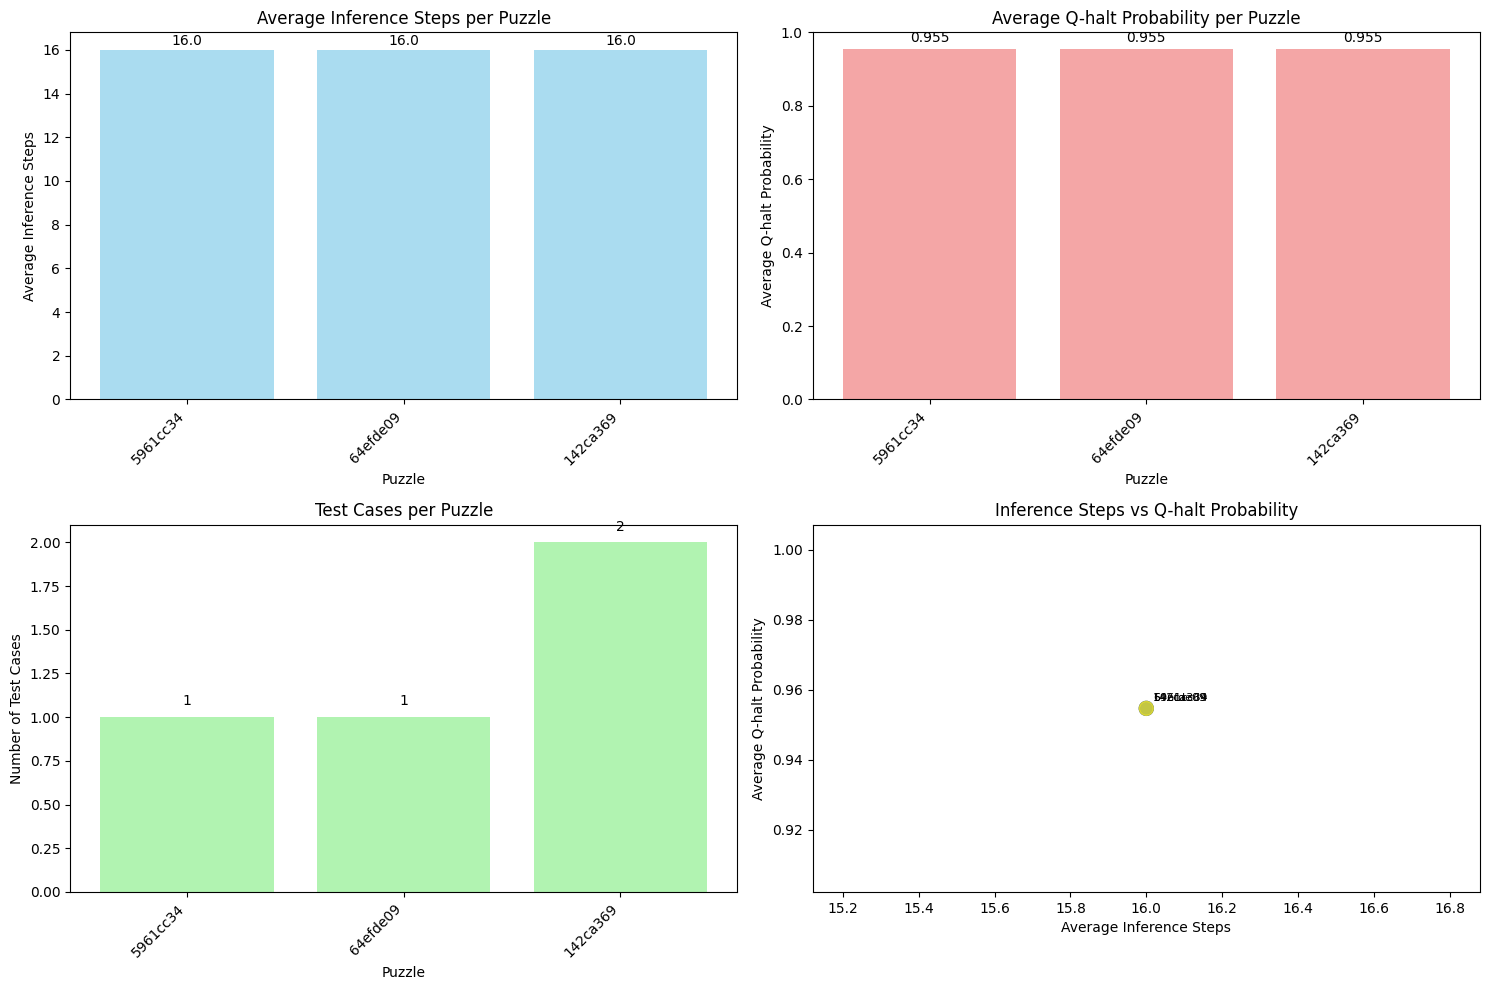


=== INFERENCE SUMMARY ===
Total puzzles processed: 3
Total test cases: 4
Average inference steps: 16.00 ± 0.00
Average Q-halt probability: 0.955 ± 0.000
Min inference steps: 16.0
Max inference steps: 16.0


In [39]:
def plot_inference_metrics(inference_results: List[Dict[str, Any]]) -> None:
    """Plot comprehensive metrics from inference results."""
    
    # Extract metrics
    puzzle_names = [r["puzzle_name"] for r in inference_results]
    avg_steps = [r["overall_metrics"]["avg_inference_steps"] for r in inference_results]
    avg_q_halt = [r["overall_metrics"]["avg_q_halt_prob"] for r in inference_results]
    total_tests = [r["overall_metrics"]["total_test_cases"] for r in inference_results]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Average inference steps per puzzle
    ax = axes[0, 0]
    bars = ax.bar(range(len(puzzle_names)), avg_steps, color='skyblue', alpha=0.7)
    ax.set_xlabel('Puzzle')
    ax.set_ylabel('Average Inference Steps')
    ax.set_title('Average Inference Steps per Puzzle')
    ax.set_xticks(range(len(puzzle_names)))
    ax.set_xticklabels(puzzle_names, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}', ha='center', va='bottom')
    
    # Plot 2: Average Q-halt probability per puzzle
    ax = axes[0, 1]
    bars = ax.bar(range(len(puzzle_names)), avg_q_halt, color='lightcoral', alpha=0.7)
    ax.set_xlabel('Puzzle')
    ax.set_ylabel('Average Q-halt Probability')
    ax.set_title('Average Q-halt Probability per Puzzle')
    ax.set_xticks(range(len(puzzle_names)))
    ax.set_xticklabels(puzzle_names, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Plot 3: Number of test cases per puzzle
    ax = axes[1, 0]
    bars = ax.bar(range(len(puzzle_names)), total_tests, color='lightgreen', alpha=0.7)
    ax.set_xlabel('Puzzle')
    ax.set_ylabel('Number of Test Cases')
    ax.set_title('Test Cases per Puzzle')
    ax.set_xticks(range(len(puzzle_names)))
    ax.set_xticklabels(puzzle_names, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{int(height)}', ha='center', va='bottom')
    
    # Plot 4: Scatter plot of steps vs Q-halt probability
    ax = axes[1, 1]
    scatter = ax.scatter(avg_steps, avg_q_halt, s=100, alpha=0.7, c=range(len(puzzle_names)), cmap='viridis')
    ax.set_xlabel('Average Inference Steps')
    ax.set_ylabel('Average Q-halt Probability')
    ax.set_title('Inference Steps vs Q-halt Probability')
    
    # Add puzzle name annotations
    for i, name in enumerate(puzzle_names):
        ax.annotate(name, (avg_steps[i], avg_q_halt[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== INFERENCE SUMMARY ===")
    print(f"Total puzzles processed: {len(inference_results)}")
    print(f"Total test cases: {sum(total_tests)}")
    print(f"Average inference steps: {np.mean(avg_steps):.2f} ± {np.std(avg_steps):.2f}")
    print(f"Average Q-halt probability: {np.mean(avg_q_halt):.3f} ± {np.std(avg_q_halt):.3f}")
    print(f"Min inference steps: {min(avg_steps):.1f}")
    print(f"Max inference steps: {max(avg_steps):.1f}")

# Plot metrics
plot_inference_metrics(inference_results)


## Model Performance Summary

Generate a comprehensive summary of the model's performance.


In [40]:
def generate_performance_summary(inference_results: List[Dict[str, Any]], model: nn.Module) -> None:
    """Generate a comprehensive performance summary."""
    
    print("\n" + "="*60)
    print("           TRM MODEL INFERENCE SUMMARY")
    print("="*60)
    
    # Model information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n📊 MODEL INFORMATION:")
    print(f"  Model type: Tiny Recursive Reasoning Model (TRM)")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Device: {device}")
    print(f"  Checkpoint: {CONFIG['checkpoint_path']}")
    
    # Dataset information
    print(f"\n📁 DATASET INFORMATION:")
    print(f"  Data path: {CONFIG['data_path']}")
    if metadata:
        print(f"  Vocab size: {metadata.vocab_size}")
        print(f"  Sequence length: {metadata.seq_len}")
        print(f"  Total puzzles: {metadata.total_puzzles}")
    
    # Inference results
    total_puzzles = len(inference_results)
    total_test_cases = sum(r["overall_metrics"]["total_test_cases"] for r in inference_results)
    
    all_steps = []
    all_q_halt = []
    
    for result in inference_results:
        for test_case in result["test_cases"]:
            all_steps.append(test_case["metrics"]["inference_steps"])
            all_q_halt.append(test_case["metrics"]["q_halt_prob"])
    
    print(f"\n🔍 INFERENCE RESULTS:")
    print(f"  Puzzles processed: {total_puzzles}")
    print(f"  Total test cases: {total_test_cases}")
    print(f"  Average inference steps: {np.mean(all_steps):.2f} ± {np.std(all_steps):.2f}")
    print(f"  Average Q-halt probability: {np.mean(all_q_halt):.3f} ± {np.std(all_q_halt):.3f}")
    print(f"  Min inference steps: {min(all_steps)}")
    print(f"  Max inference steps: {max(all_steps)}")
    
    # Performance insights
    print(f"\n💡 PERFORMANCE INSIGHTS:")
    
    if np.mean(all_steps) < 5:
        print("  ✅ Model converges quickly (low inference steps)")
    elif np.mean(all_steps) > 15:
        print("  ⚠️  Model takes many steps to converge")
    else:
        print("  ✅ Model has reasonable convergence speed")
    
    if np.mean(all_q_halt) > 0.7:
        print("  ✅ Model has high confidence in halting decisions")
    elif np.mean(all_q_halt) < 0.3:
        print("  ⚠️  Model has low confidence in halting decisions")
    else:
        print("  ✅ Model has moderate confidence in halting decisions")
    
    # Variability analysis
    steps_cv = np.std(all_steps) / np.mean(all_steps) if np.mean(all_steps) > 0 else 0
    if steps_cv < 0.3:
        print("  ✅ Low variability in inference steps (consistent performance)")
    elif steps_cv > 0.7:
        print("  ⚠️  High variability in inference steps (inconsistent performance)")
    else:
        print("  ✅ Moderate variability in inference steps")
    
    print(f"\n📈 RECOMMENDATIONS:")
    if np.mean(all_steps) > 10:
        print("  • Consider reducing halt_max_steps or adjusting halt_exploration_prob")
    if np.mean(all_q_halt) < 0.5:
        print("  • Consider adjusting Q-halt loss weight or training longer")
    if steps_cv > 0.5:
        print("  • Consider analyzing puzzle difficulty and model consistency")
    
    print("\n" + "="*60)

# Generate performance summary
generate_performance_summary(inference_results, model)



           TRM MODEL INFERENCE SUMMARY

📊 MODEL INFORMATION:
  Model type: Tiny Recursive Reasoning Model (TRM)
  Total parameters: 6,829,058
  Trainable parameters: 6,829,058
  Device: cuda
  Checkpoint: checkpoints/downloaded/Sanjin2024_TinyRecursiveModels-ARC-AGI-2/step_217602

📁 DATASET INFORMATION:
  Data path: data/arc2eval-aug-200
  Vocab size: 12
  Sequence length: 900
  Total puzzles: 23991

🔍 INFERENCE RESULTS:
  Puzzles processed: 3
  Total test cases: 4
  Average inference steps: 16.00 ± 0.00
  Average Q-halt probability: 0.955 ± 0.000
  Min inference steps: 16
  Max inference steps: 16

💡 PERFORMANCE INSIGHTS:
  ⚠️  Model takes many steps to converge
  ✅ Model has high confidence in halting decisions
  ✅ Low variability in inference steps (consistent performance)

📈 RECOMMENDATIONS:
  • Consider reducing halt_max_steps or adjusting halt_exploration_prob



## Save Results

Save the inference results and visualizations for later analysis.


In [ ]:
def save_inference_results(inference_results: List[Dict[str, Any]], output_dir: str = "inference_outputs") -> None:
    """Save inference results to files."""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Save raw results as JSON
    results_file = os.path.join(output_dir, "inference_results.json")
    
    # Convert numpy arrays to lists for JSON serialization
    serializable_results = []
    for result in inference_results:
        serializable_result = {
            "puzzle_name": result["puzzle_name"],
            "overall_metrics": result["overall_metrics"],
            "test_cases": []
        }
        
        for test_case in result["test_cases"]:
            serializable_test_case = {
                "test_idx": test_case["test_idx"],
                "metrics": test_case["metrics"],
                "input_grid": test_case["input_grid"].tolist(),
                "expected_grid": test_case["expected_grid"].tolist(),
                "predictions": test_case["predictions"].tolist() if hasattr(test_case["predictions"], 'tolist') else str(test_case["predictions"])
            }
            serializable_result["test_cases"].append(serializable_test_case)
        
        serializable_results.append(serializable_result)
    
    with open(results_file, "w") as f:
        json.dump(serializable_results, f, indent=2)
    
    print(f"Results saved to {results_file}")
    
    # Save configuration
    config_file = os.path.join(output_dir, "inference_config.json")
    with open(config_file, "w") as f:
        json.dump(CONFIG, f, indent=2)
    
    print(f"Configuration saved to {config_file}")
    
    # Create a summary report
    report_file = os.path.join(output_dir, "inference_report.txt")
    with open(report_file, "w") as f:
        f.write("TRM Model Inference Report\\n")
        f.write("="*50 + "\\n\\n")
        f.write(f"Checkpoint: {CONFIG['checkpoint_path']}\\n")
        f.write(f"Data path: {CONFIG['data_path']}\\n")
        f.write(f"Puzzles processed: {len(inference_results)}\\n")
        f.write(f"Total test cases: {sum(r['overall_metrics']['total_test_cases'] for r in inference_results)}\\n\\n")
        
        all_steps = []
        all_q_halt = []
        for result in inference_results:
            for test_case in result["test_cases"]:
                all_steps.append(test_case["metrics"]["inference_steps"])
                all_q_halt.append(test_case["metrics"]["q_halt_prob"])
        
        f.write(f"Average inference steps: {np.mean(all_steps):.2f} ± {np.std(all_steps):.2f}\\n")
        f.write(f"Average Q-halt probability: {np.mean(all_q_halt):.3f} ± {np.std(all_q_halt):.3f}\\n")
        f.write(f"Min inference steps: {min(all_steps)}\\n")
        f.write(f"Max inference steps: {max(all_steps)}\\n")
    
    print(f"Report saved to {report_file}")
    print(f"\\nAll files saved to directory: {output_dir}")

# Save results
save_inference_results(inference_results)


## Conclusion

This notebook demonstrates how to:

1. **Load a trained TRM model** from checkpoint with proper configuration
2. **Run inference** on specific puzzles with detailed metrics collection
3. **Visualize results** showing inputs, expected outputs, and model predictions
4. **Analyze performance** with comprehensive metrics and plots
5. **Save results** for further analysis

### Key Metrics Tracked:
- **Inference steps**: Number of recursive reasoning steps taken
- **Q-halt probability**: Model's confidence in halting decisions
- **Accuracy metrics**: Token-level and sequence-level accuracy
- **Convergence patterns**: How quickly the model reaches solutions

### Next Steps:
- Modify the configuration to use your specific model checkpoint and dataset
- Adjust the visualization parameters for your specific puzzle types
- Extend the analysis to include additional metrics relevant to your use case
- Use the saved results for further analysis or comparison with other models
